<h1 style="color:Black;text-align:center">Saed - Call volumes and other stuff</h1>

In [1]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
from scipy import stats
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import chisquare

C:\Users\saadm\Anaconda2\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
calls = pd.read_csv("../data/callsForServiceUpdated.csv")

C:\Users\saadm\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Cleaning up the data

In [3]:
calls = calls[calls.rptonly != True]
calls = calls[calls.cancelled != True]
calls = calls[calls.nature != 'TRANSPORT TO ANIMAL SHELTER']
calls['calltime'] = pd.to_datetime(calls.calltime)
calls['year'] = calls.calltime.apply(lambda x: x.date().year)
calls['month'] = calls.calltime.apply(lambda x: x.date().month)
calls['dayOfMonth'] = calls.calltime.apply(lambda x: x.date().day)
calls['hour'] = calls.calltime.apply(lambda x: x.time().hour)
calls['minute'] = calls.calltime.apply(lambda x: x.time().minute)
calls['second'] = calls.calltime.apply(lambda x: x.time().second)
calls = calls.rename(columns={'calldow' : 'dayOfWeek'})
calls = calls.drop(columns = ['timeclose'], axis = 1)
calls = calls.drop(columns = ['statbeat','ra'])
calls['callsourcecode'] = calls.callsource.astype('category').cat.codes
calls['citycode'] = calls.city.astype('category').cat.codes
calls['agencycode'] = calls.agency.astype('category').cat.codes
calls['streetonlycode'] = calls.streetonly.astype('category').cat.codes
calls

,inci_id,parent_id,case_id,calltime,callsource,street,city,streetonly,geox,geoy,...,year,month,dayOfMonth,hour,minute,second,callsourcecode,citycode,agencycode,streetonlycode
0,2012324665,NaN,NaN,2012-07-01 00:01:15,SELF,OLD RANDLEMAN RD/COLTRANE MILL RD,G,OLD RANDLEMAN RD/COLTRANE MILL RD,1755293.88,800660.13,...,2012,7,1,0,1,15,15,11,3,16672
1,2012324676,NaN,1234238.0,2012-07-01 00:09:07,E911,312 MARTIN LUTHER KING JR DR,G,MARTIN LUTHER KING JR DR,1767127.13,843918.75,...,2012,7,1,0,9,7,4,11,1,13653
3,2012324690,NaN,1234239.0,2012-07-01 00:15:56,E911,3905 BROOKHOLLOW RD,W,BROOKHOLLOW RD,1808054.75,822506.31,...,2012,7,1,0,15,56,4,28,1,2727
4,2012324692,2.012325e+09,1206134.0,2012-07-01 00:17:20,E911,3905 BROOKHOLLOW RD,W,BROOKHOLLOW RD,1808054.75,822506.31,...,2012,7,1,0,17,20,4,28,2,2727
5,2012324697,NaN,1234240.0,2012-07-01 00:19:24,E911,5125 MICHAUX RD,G,MICHAUX RD,1744080.88,874458.88,...,2012,7,1,0,19,24,4,11,1,14271
6,2012324704,NaN,1234241.0,2012-07-01 00:24:42,E911,1409 DANS RD,G,DANS RD,1778039.38,840417.56,...,2012,7,1,0,24,42,4,11,1,5204
7,2012324709,NaN,NaN,2012-07-01 00:29:23,SELF,8069 HAW RIVER RD,ST,HAW RIVER RD,1709461.00,897647.69,...,2012,7,1,0,29,23,15,26,3,9542
8,2012324711,NaN,1234242.0,2012-07-01 00:30:03,W911,WESTCHESTER DR/N MAIN ST,H,WESTCHESTER DR/N MAIN ST,1697332.38,814158.75,...,2012,7,1,0,30,3,20,13,1,24707
9,2012324715,NaN,NaN,2012-07-01 00:33:11,PHONE,8403 MEARS FORK RD,SU,MEARS FORK RD,1759324.13,906703.25,...,2012,7,1,0,33,11,11,27,3,14145
10,2012324719,NaN,NaN,2012-07-01 00:37:41,SELF,401 W SYCAMORE ST,G,W SYCAMORE ST,1765195.63,845899.75,...,2012,7,1,0,37,41,15,11,3,24068


#### Saving it to a new file to start from next time.

In [4]:
calls.to_csv('../data/cleaneddata.csv')

In [5]:
calls = pd.read_csv('../data/cleaneddata.csv')

C:\Users\saadm\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (12,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<p>Here, we are just counting the number of <b>nulls</b> per each column, and displaying the datetype if it's not object.<br>If it is an object, we display the number of categories, in other words, the number of <b>distinct</b> values in that column.</p>

In [6]:
k = 0
for i in calls.columns:
    dtype = calls.dtypes[k].name
    if dtype == 'object':
        print i, ": nulls = ", len(calls.loc[calls[i].isnull()]), ", categories = ", \
        len(calls[i].astype('category').cat.categories)
    else:
        print i, ": nulls = ", len(calls.loc[calls[i].isnull()]), ", type = ", dtype
    k+=1

Unnamed: 0 : nulls =  0 , type =  int64
inci_id : nulls =  0 , type =  int64
parent_id : nulls =  953924 , type =  float64
case_id : nulls =  485418 , type =  float64
calltime : nulls =  0 , categories =  1061228
callsource : nulls =  3 , categories =  22
street : nulls =  0 , categories =  165666
city : nulls =  681 , categories =  30
streetonly : nulls =  235 , categories =  25910
geox : nulls =  0 , type =  float64
geoy : nulls =  0 , type =  float64
nature : nulls =  0 , categories =  259
nature2 : nulls =  986975 , categories =  167
priority : nulls =  243 , categories =  10
medprior : nulls =  0 , type =  int64
meddislvl : nulls =  652769 , categories =  1771
rptonly : nulls =  0 , type =  bool
service : nulls =  0 , categories =  5
agency : nulls =  0 , categories =  4
district : nulls =  80499 , categories =  63
gp : nulls =  83801 , categories =  857
primeunit : nulls =  429 , categories =  1213
cancelled : nulls =  0 , type =  bool
closecode : nulls =  566 , categories =  58


In [7]:
print "The number of rows that have NaN values in district, statbeat, ra, and gp = ", \
len(calls.loc[calls['district'].isnull() & calls['gp'].isnull()])

The number of rows that have NaN values in district, statbeat, ra, and gp =  80488


## Cities vs County

In [8]:
total_calls = len(calls)
city_vol = dict()
for city in calls.city.unique():
    if str(city) != 'nan':
        total_calls_city = len(calls.loc[calls.city == city])
    else:
        total_calls_city = len(calls.loc[calls.city.isnull()])
    percentage = total_calls_city*10000/total_calls
    city_vol[str(city)] = percentage

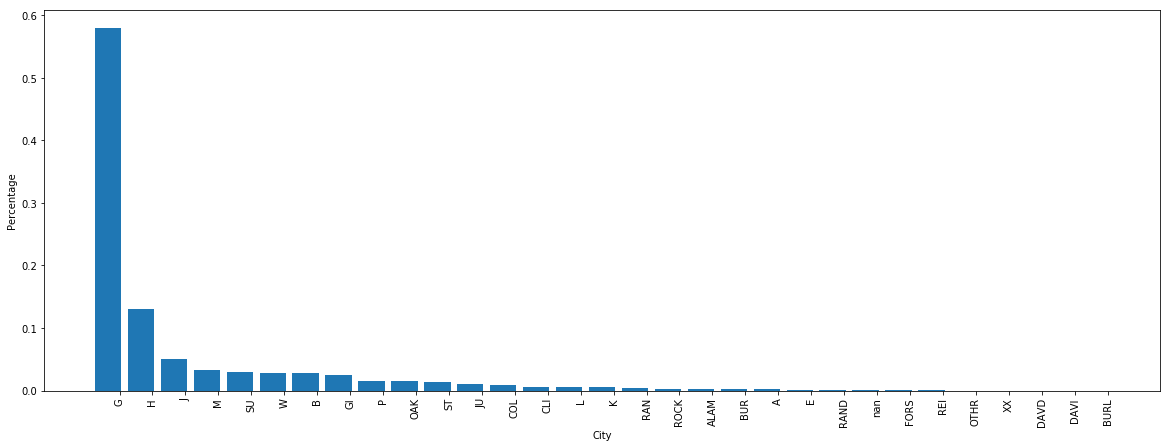

In [9]:
counts = Counter(calls.city)

labels, values = zip(*counts.items())

indSort = np.argsort(values)[::-1]

labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.figure(figsize=(20,7))
plt.bar(indexes, values*1.0/len(calls))
plt.xticks(indexes + bar_width, labels, rotation = 90)
plt.xlabel("City")
plt.ylabel("Percentage")
plt.savefig("cities.png", dpi=300)
plt.show()


#### This function plots a City's Data against County's Data

In [10]:
def plot_city_county(calls, mycity):
    plt.figure(figsize=(20,42))
    rng = np.arange(2012,2020)
    plt.subplot(5,2,1).set_title('Year - Guilford county')
    plt.xticks(rng)
    plt.xlim(rng.min()-0.7, rng.max()-0.3)
    plt.hist(calls.year, bins=rng-0.5, rwidth=0.75)

    rng = np.arange(1,14)
    plt.subplot(5,2,3).set_title('Month - Guilford county')
    plt.xticks(rng)
    plt.xlim(rng.min()-0.7, rng.max()-0.3)
    plt.hist(calls.month, bins=rng-0.5, rwidth=0.75, normed=True)

    rng = np.arange(1,33)
    plt.subplot(5,2,5).set_title('Day of Month - Guilford county')
    plt.xticks(rng)
    plt.xlim(rng.min()-0.7, rng.max()-0.3)
    plt.hist(calls.dayOfMonth, bins=rng-0.5, rwidth=0.75, normed=True)

    rng = np.arange(1,9)
    plt.subplot(5,2,7).set_title('Day of Week - Guilford county')
    plt.xticks(rng, ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
    plt.xlim(rng.min()-0.7, rng.max()-0.3)
    plt.hist(calls.dayOfWeek, bins=rng-0.5, rwidth=0.75, normed=True)

    rng = np.arange(0,25)
    plt.subplot(5,2,9).set_title('Hour - Guilford county')
    plt.xticks(rng)
    plt.xlim(rng.min()-0.7, rng.max()-0.3)
    plt.hist(calls.hour, bins=rng-0.5, rwidth=0.75, normed=True)
    
    rng = np.arange(2012,2020)
    plt.subplot(5,2,2).set_title('Year - "' + mycity + '" city')
    plt.xticks(rng)
    plt.xlim(rng.min()-0.7, rng.max()-0.3)
    plt.hist(calls.loc[calls.city == mycity].year, bins=rng-0.5, rwidth=0.75)

    rng = np.arange(1,14)
    plt.subplot(5,2,4).set_title('Month - "' + mycity + '" city')
    plt.xticks(rng)
    plt.xlim(rng.min()-0.7, rng.max()-0.3)
    plt.hist(calls.loc[calls.city == mycity].month, bins=rng-0.5, rwidth=0.75, normed=True)

    rng = np.arange(1,33)
    plt.subplot(5,2,6).set_title('Day of Month - "' + mycity + '" city')
    plt.xticks(rng)
    plt.xlim(rng.min()-0.7, rng.max()-0.3)
    plt.hist(calls.loc[calls.city == mycity].dayOfMonth, bins=rng-0.5, rwidth=0.75, normed=True)

    rng = np.arange(1,9)
    plt.subplot(5,2,8).set_title('Day of Week - "' + mycity + '" city')
    plt.xticks(rng, ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
    plt.xlim(rng.min()-0.7, rng.max()-0.3)
    plt.hist(calls.loc[calls.city == mycity].dayOfWeek, bins=rng-0.5, rwidth=0.75, normed=True)

    rng = np.arange(0,25)
    plt.subplot(5,2,10).set_title('Hour - "' + mycity + '" city')
    plt.xticks(rng)
    plt.xlim(rng.min()-0.7, rng.max()-0.3)
    plt.hist(calls.loc[calls.city == mycity].hour, bins=rng-0.5, rwidth=0.75, normed=True)

C:\Users\saadm\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


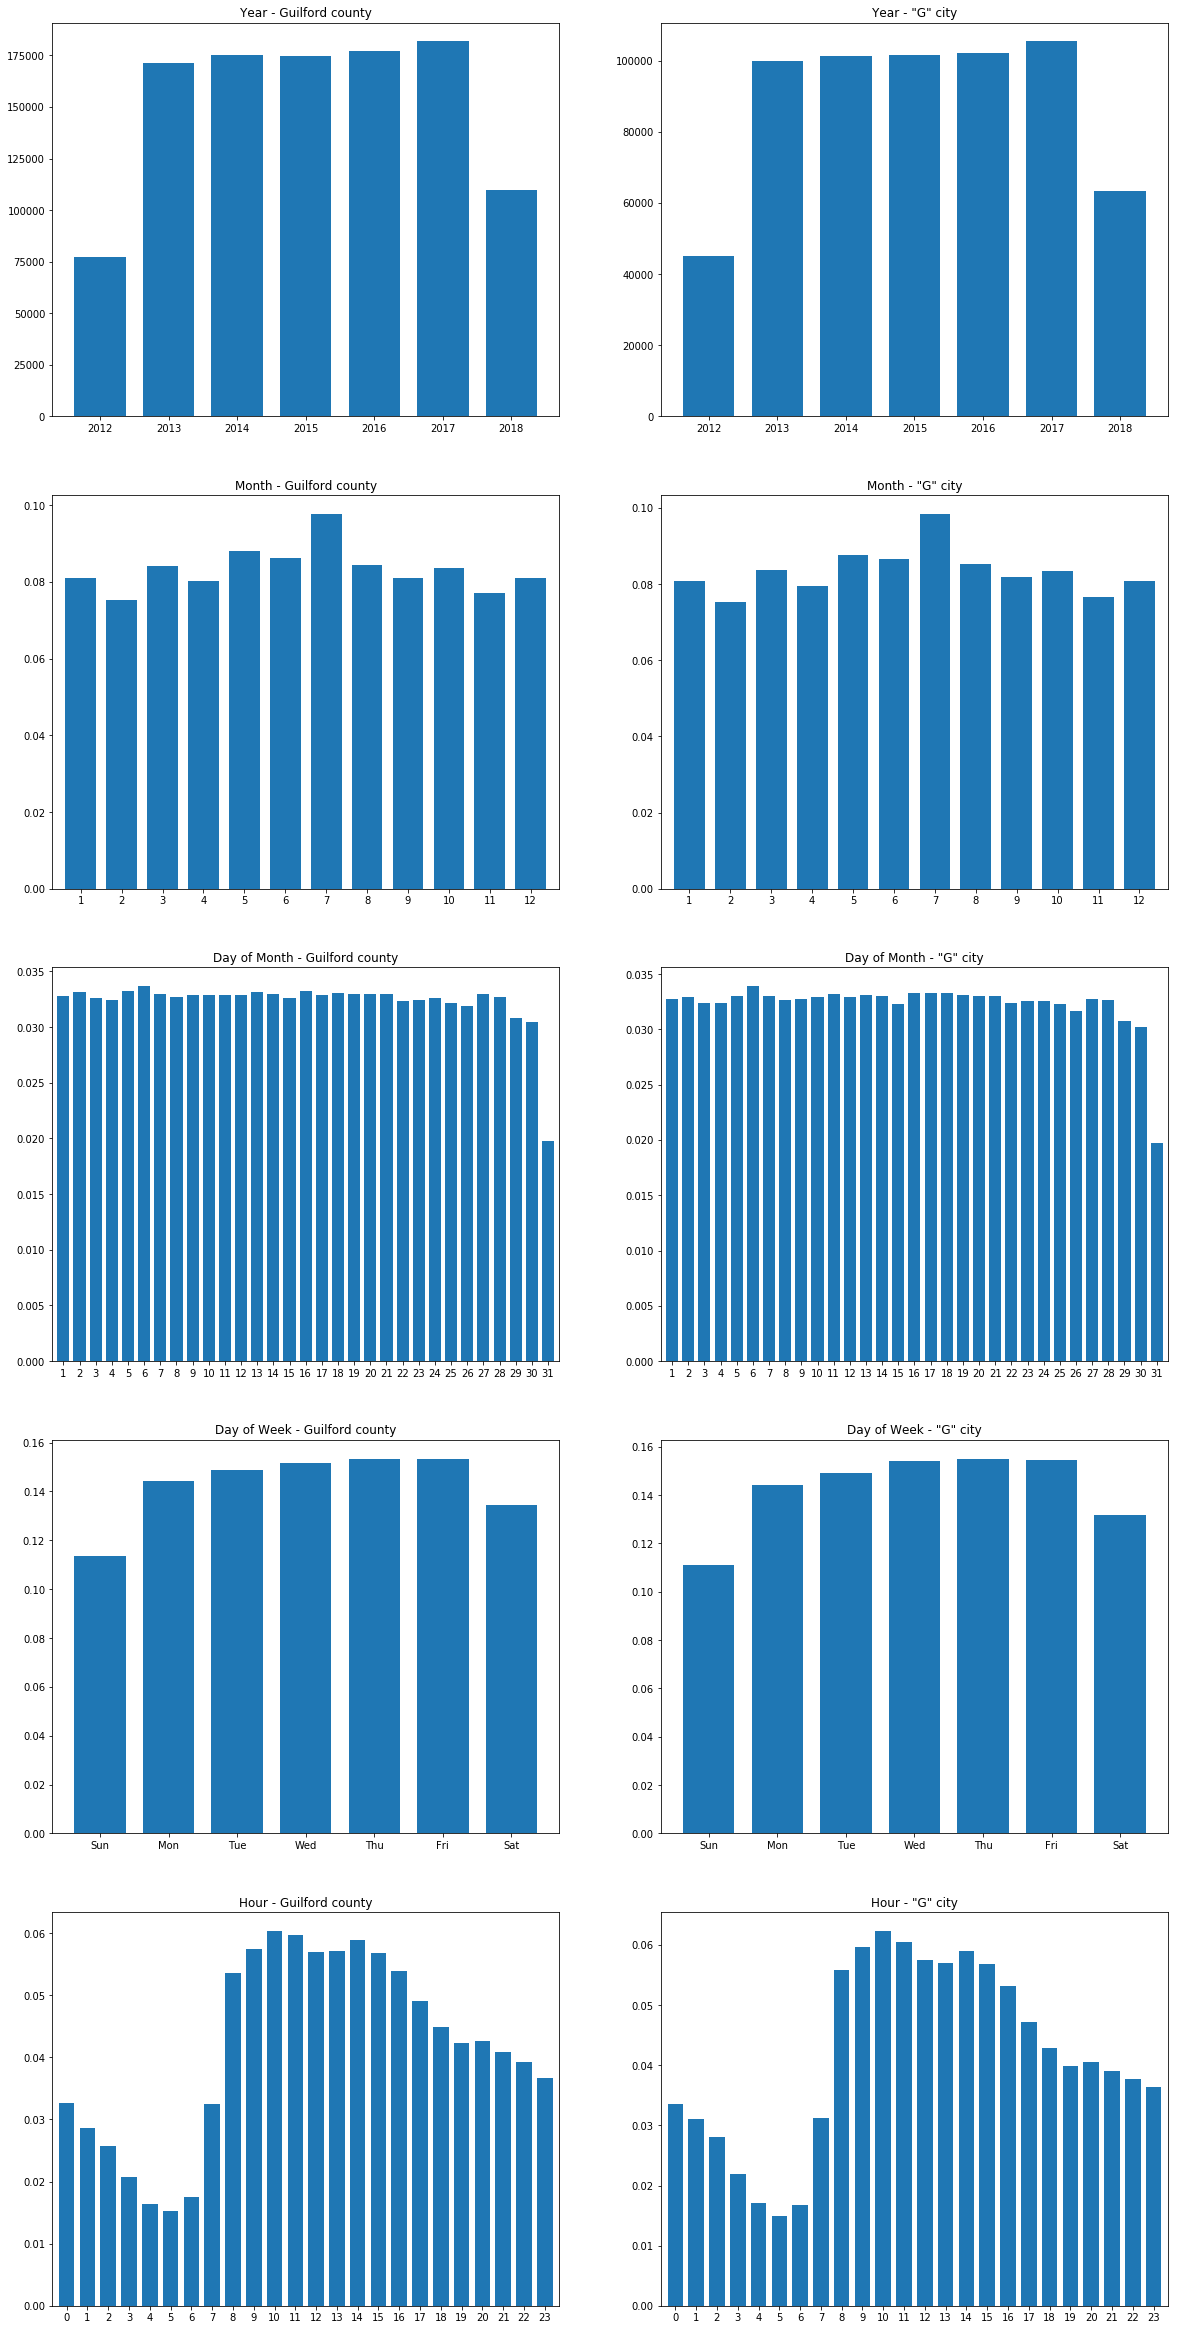

In [11]:
plot_city_county(calls, 'G')
plt.savefig("guilford_gboro.png", dpi=300)

To compare the previous graphs, we can use a statistical method called <b> Kolmogorov–Smirnov test </b>.

The lower the value it returns, the more of a chance that those sets are drawn from the same continuous distribution, for the sake of simplicity, we will call this value a 'mismatch percentage'.

In [12]:
for city in calls.city.unique():
    if str(city) != 'nan':
        total_calls_city = len(calls.loc[calls.city == city])
    else:
        continue
    print "The mismatch percentage with city '{0}' regarding call natures is {2} (For {1} calls).".format(city, total_calls_city, stats.ks_2samp(calls.loc[calls.city == city].nature.astype('category').cat.codes, calls.nature.astype('category').cat.codes))

The mismatch percentage with city 'G' regarding call natures is Ks_2sampResult(statistic=0.07593253483486984, pvalue=0.0) (For 618589 calls).
The mismatch percentage with city 'W' regarding call natures is Ks_2sampResult(statistic=0.3669479292826072, pvalue=0.0) (For 30624 calls).
The mismatch percentage with city 'ST' regarding call natures is Ks_2sampResult(statistic=0.39872292211695415, pvalue=0.0) (For 15133 calls).
The mismatch percentage with city 'H' regarding call natures is Ks_2sampResult(statistic=0.3916550932842192, pvalue=0.0) (For 138414 calls).
The mismatch percentage with city 'SU' regarding call natures is Ks_2sampResult(statistic=0.36445280568188565, pvalue=0.0) (For 31617 calls).
The mismatch percentage with city 'CLI' regarding call natures is Ks_2sampResult(statistic=0.44805541827350925, pvalue=0.0) (For 6222 calls).
The mismatch percentage with city 'P' regarding call natures is Ks_2sampResult(statistic=0.38763469608773915, pvalue=0.0) (For 16288 calls).
The mismat

## Top Natures for each month

In [13]:
data = calls.groupby(['month','nature']).agg(['count'])['secsdi2ar']
for i in range(1,13):
    print i, " -- ", data.ix[i].sort_values('count', ascending=False).ix[0:5], '\n'

1  --                                  count
nature                               
TRAFFIC STOP                     9390
SICK PERSON                      6200
FALLS-BACK INJURIES(TRAUMATIC)   5189
BREATHING PROBLEMS               4359
CHEST PAIN                       3157 

2  --                                  count
nature                               
TRAFFIC STOP                     9148
SICK PERSON                      5424
FALLS-BACK INJURIES(TRAUMATIC)   4826
BREATHING PROBLEMS               3721
CHEST PAIN                       2769 

3  --                                  count
nature                               
TRAFFIC STOP                    10040
SICK PERSON                      5967
FALLS-BACK INJURIES(TRAUMATIC)   5117
BREATHING PROBLEMS               4202
CHEST PAIN                       3166 

4  --                                  count
nature                               
TRAFFIC STOP                     8688
SICK PERSON                      5555
FALLS-BACK INJUR

C:\Users\saadm\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


## Total calls along the years

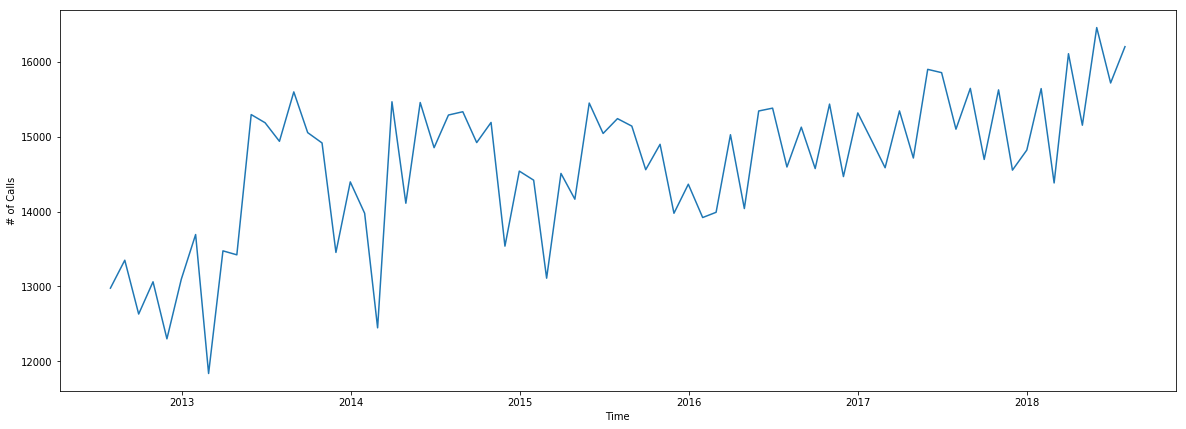

In [14]:
total_calls = calls.groupby(['year', 'month']).agg(['count'])['secsdi2ar']
plt.figure(figsize = (20,7))
t = pd.date_range('2012-07-01 00:00:00', periods=73, freq='1m')
plt.xlabel('Time')
plt.ylabel('# of Calls')
plt.plot(t, total_calls['count'].tolist())
plt.savefig('calls_yearmonth.png', dpi=300)

## Top natures across the dataset

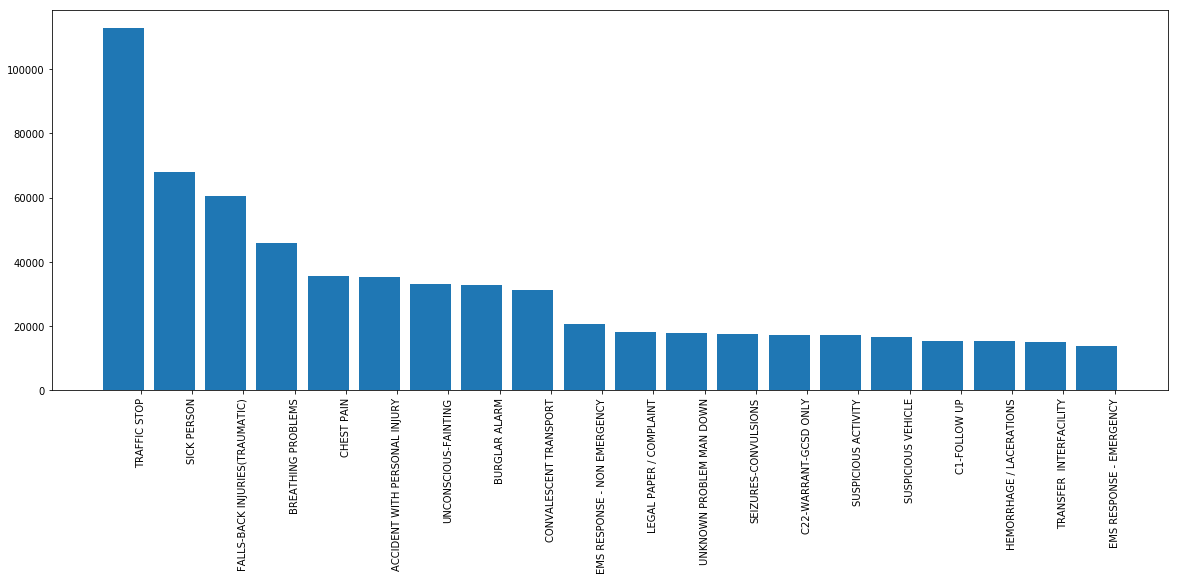

In [15]:
counts = Counter(calls.nature)

labels, values = zip(*counts.items())

indSort = np.argsort(values)[::-1][:20]

labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.figure(figsize=(20,7))
plt.bar(indexes, values)
plt.xticks(indexes + bar_width, labels, rotation = 90)
plt.show()

## Top 20 natures and their trend across the years

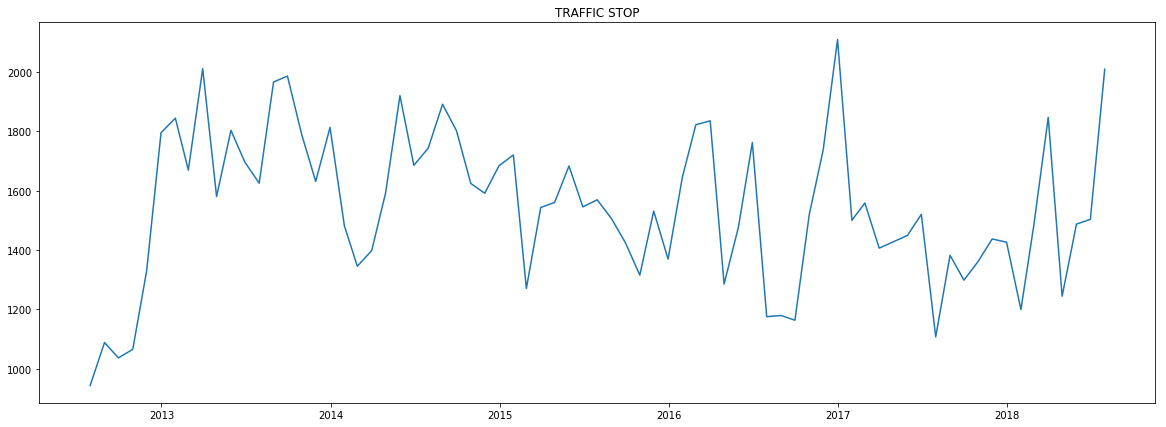

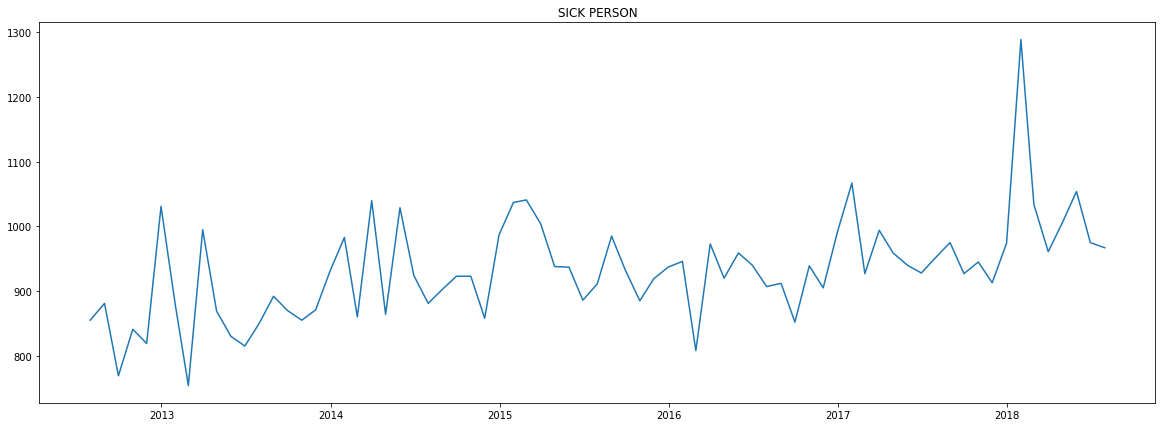

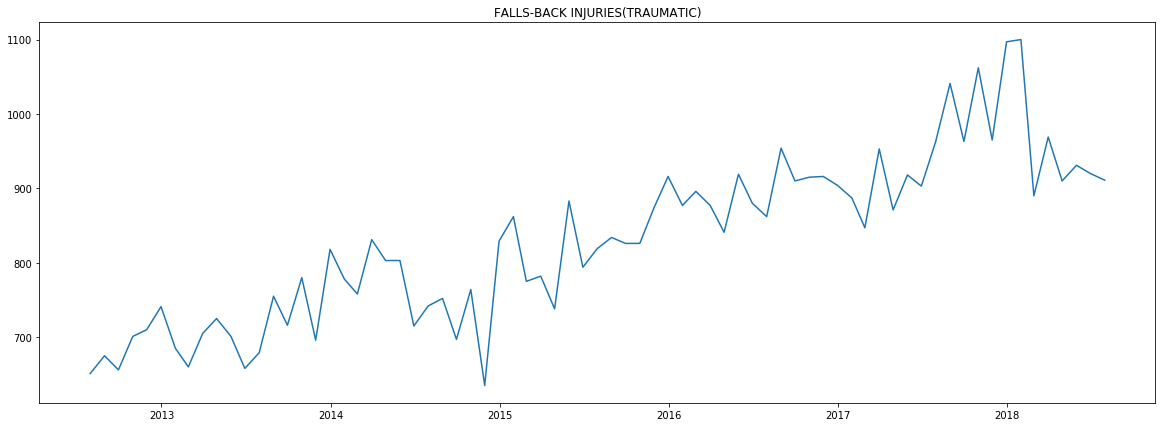

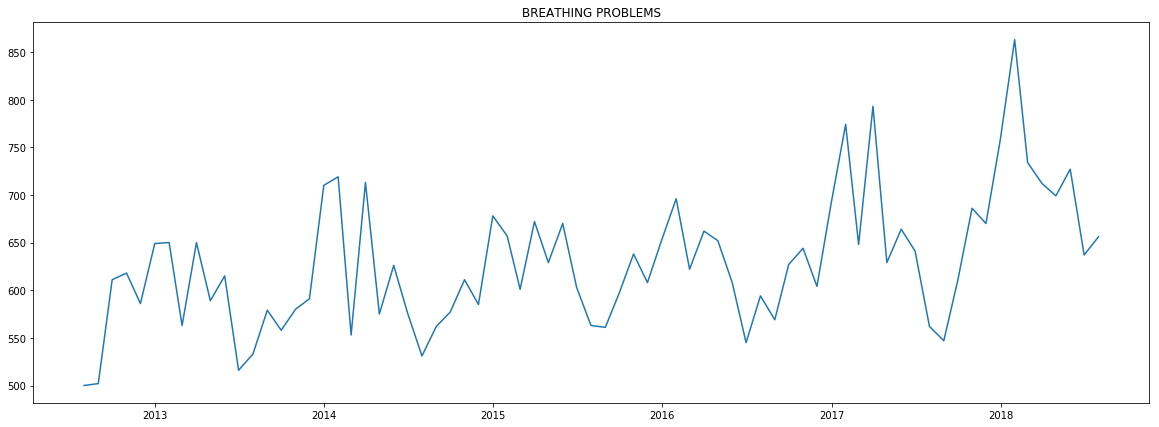

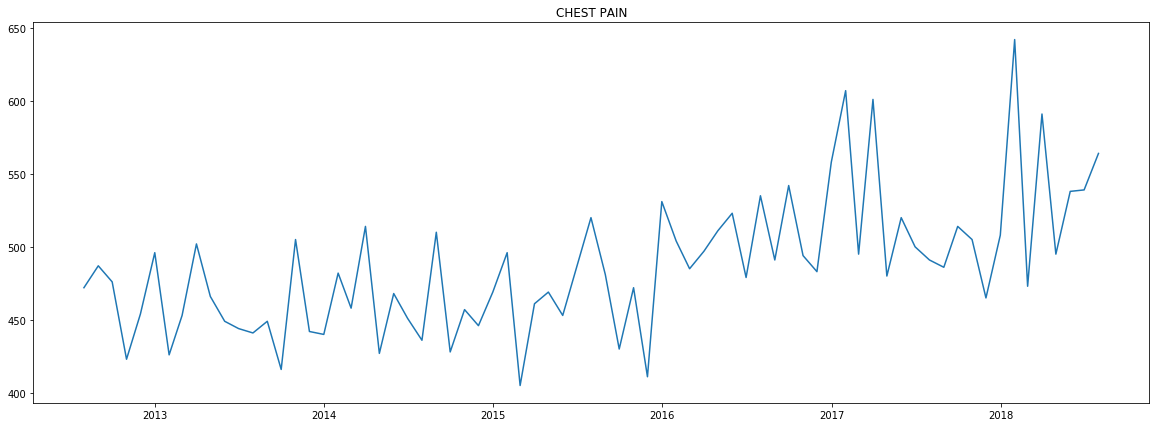

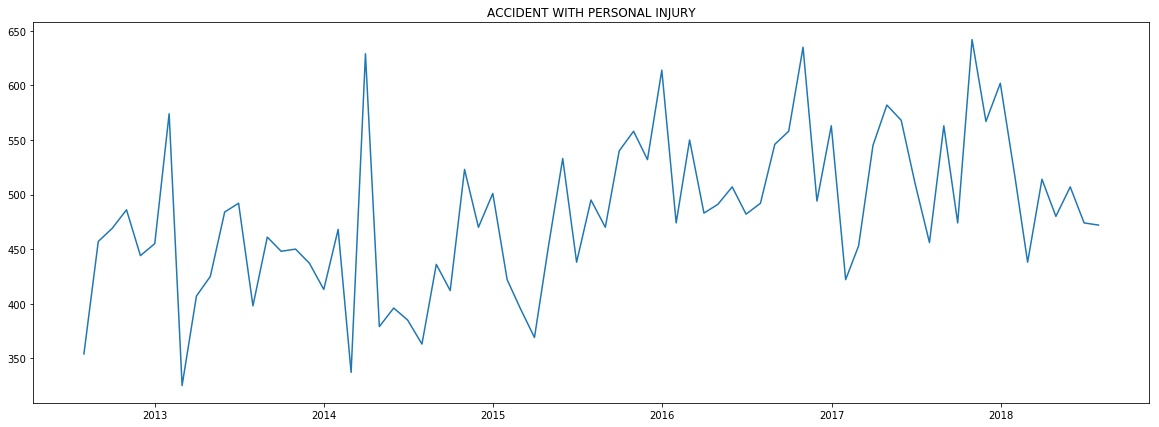

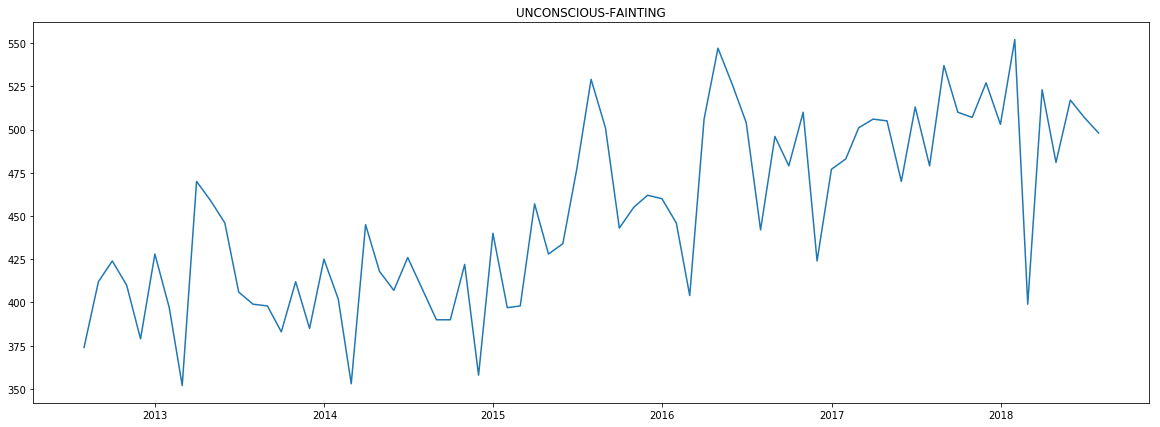

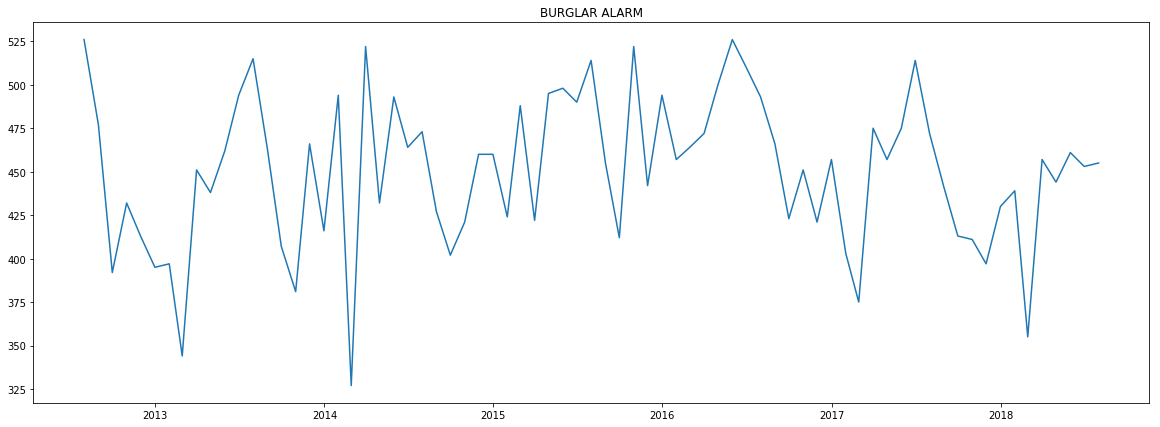

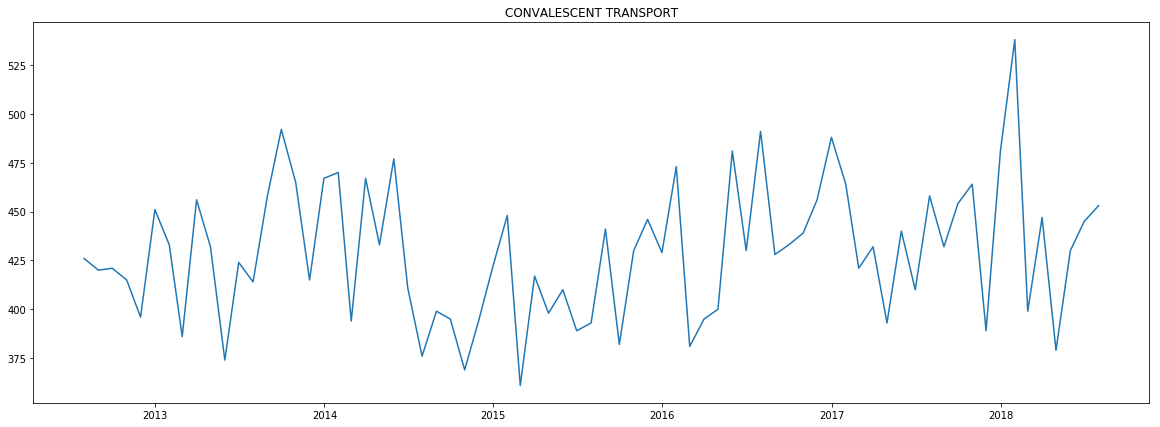

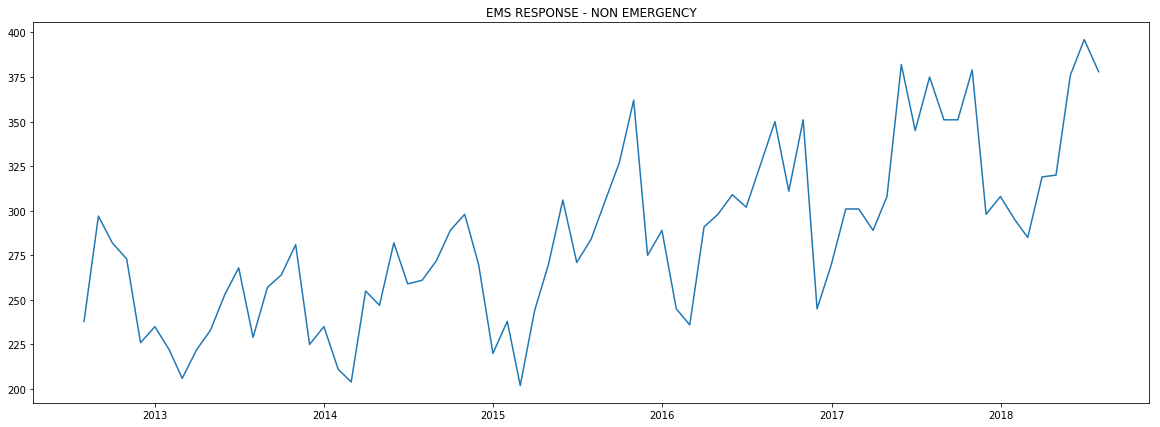

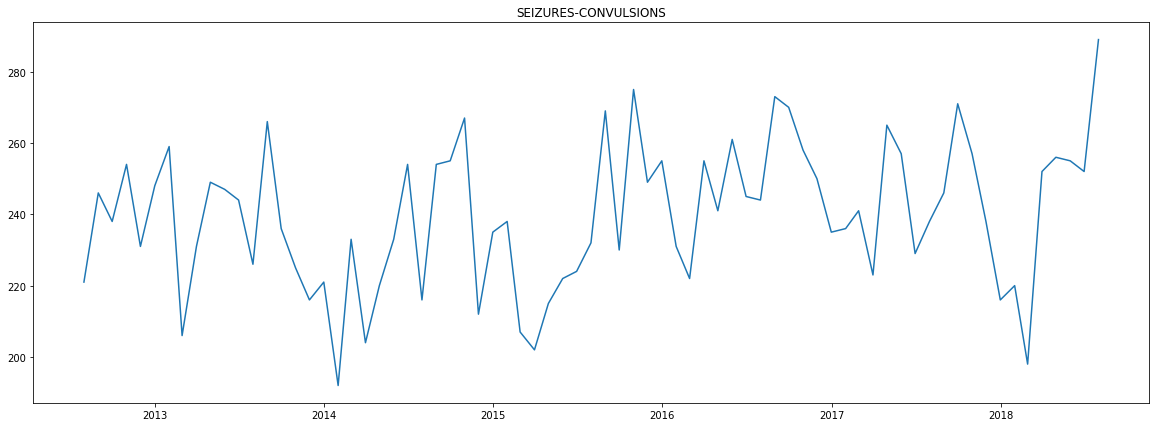

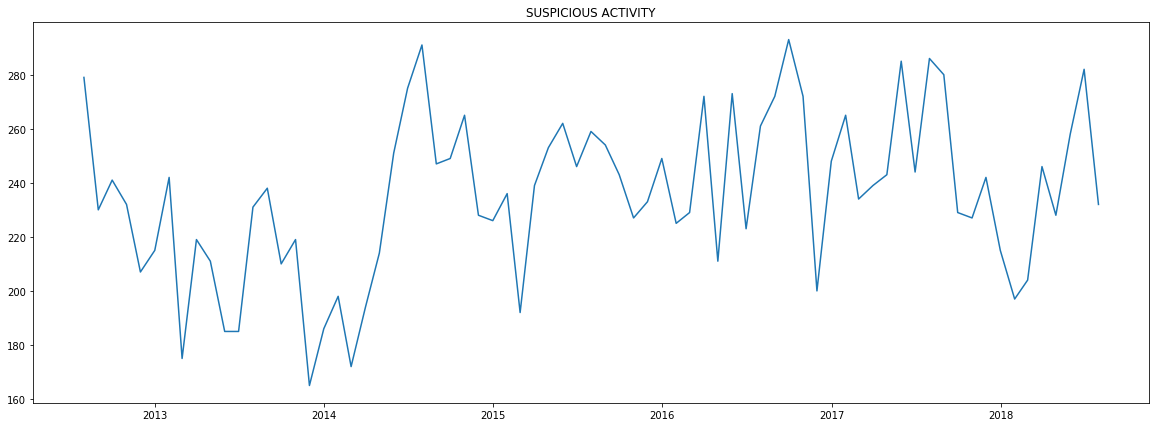

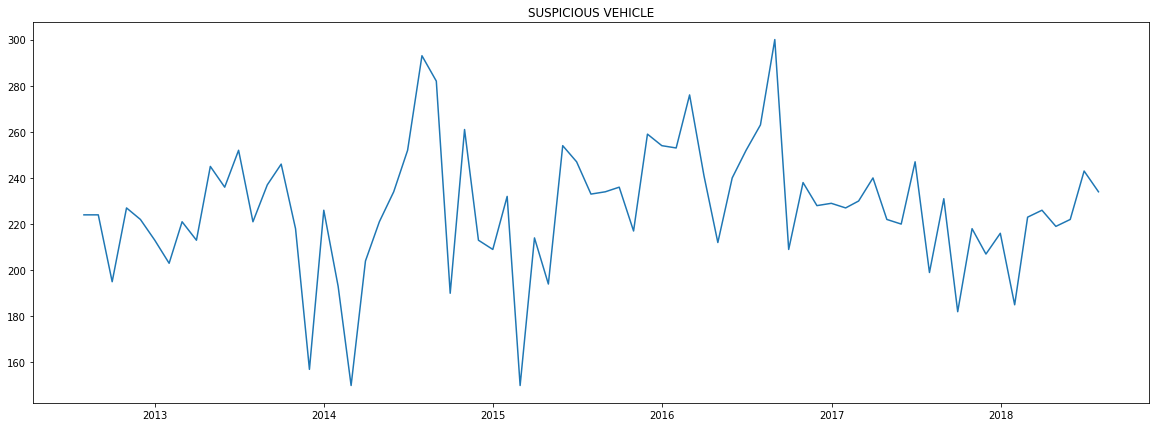

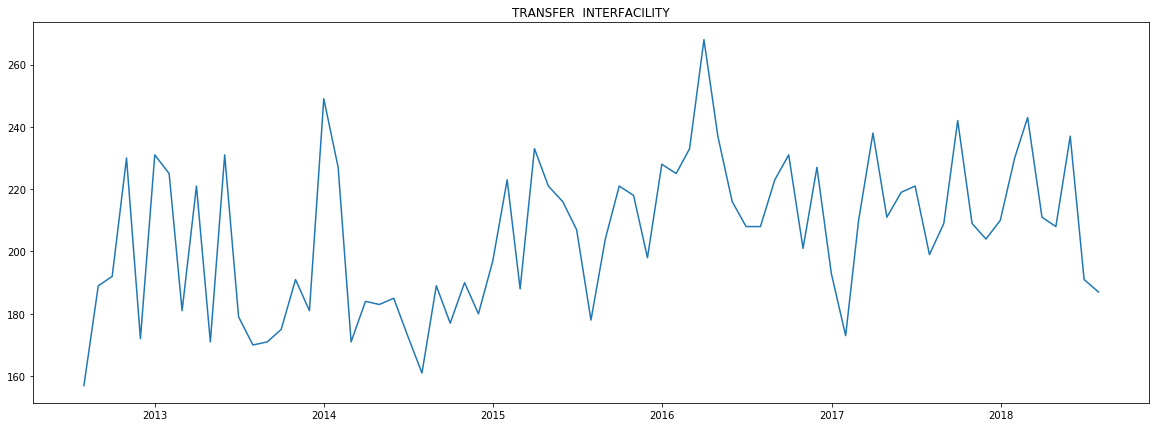

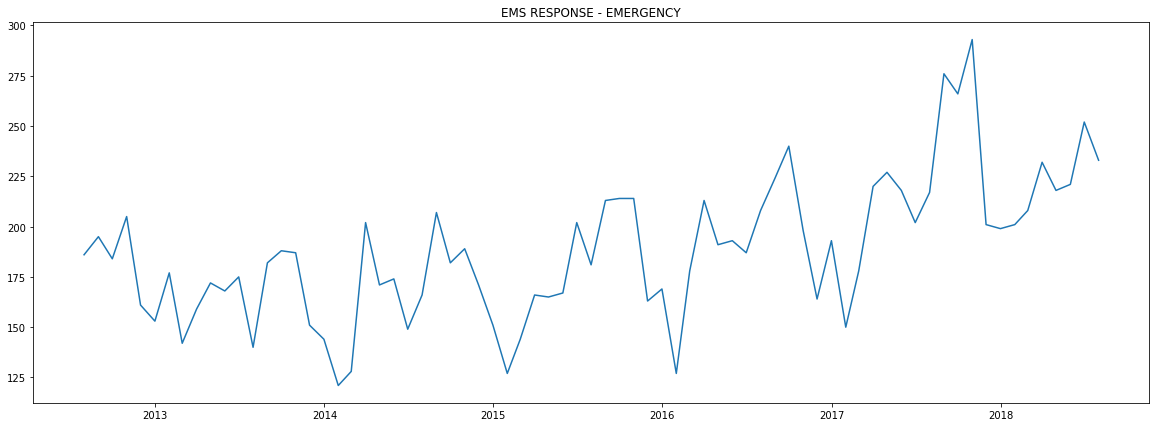

In [16]:
failed = []
average = calls.nature.value_counts() / (6 + 1.0/12) / 365
for i in average[:20].index:
    try:
        tmp = calls.loc[calls.nature == i].groupby(['year', 'month']).agg(['count'])['secsdi2ar']
        plt.figure(figsize = (20,7))
        t = pd.date_range('2012-07-01 00:00:00', periods=73, freq='1m')
        plt.title(i)
        plt.plot(t, tmp['count'].tolist())
        plt.savefig("natures/"+"".join(i.split(" "))+'.png', dpi=300)
    except:
        plt.close()
        failed.append(i)


#### This data was used for CartoDB map visualization

In [17]:
calls.loc[(calls.calltime >= '2017-09-01') & (calls.calltime <= '2017-09-30 23:59:59')][['long', 'lat', 'hour', 'agency']].to_csv('carto.csv', index=False)

##  Hypothesis testing

#### Calls - Agency distribution between Greensboro & Guilford County

In [18]:
A = np.array(calls.loc[calls.city == 'G'].agencycode)
B = calls.agencycode.mean()
stats.ttest_1samp(A, B)

Ttest_1sampResult(statistic=-139.51640049888158, pvalue=0.0)

#### Distribution of calls between agencies

In [19]:
A = [0] * 4
A[0] = np.array(calls.loc[calls.agency == 'EMS'].reset_index().hour)
A[1] = np.array(calls.loc[calls.agency == 'GCSD'].reset_index().hour)
A[2] = np.array(calls.loc[calls.agency == 'GCF'].reset_index().hour)
A[3] = np.array(calls.loc[calls.agency == 'ACO'].reset_index().hour)
for i in range(4):
    for j in range(i+1,4):
        print i, j, stats.ttest_ind(a= A[i],
                b= A[j]), '\n'

0 1 Ttest_indResult(statistic=30.795979763901883, pvalue=3.7996556465226107e-208) 

0 2 Ttest_indResult(statistic=-11.39083680123444, pvalue=4.681390934892293e-30) 

0 3 Ttest_indResult(statistic=43.79335949302234, pvalue=0.0) 

1 2 Ttest_indResult(statistic=-27.869818633983193, pvalue=8.283580692073324e-171) 

1 3 Ttest_indResult(statistic=25.297451697048437, pvalue=4.1526842584738626e-141) 

2 3 Ttest_indResult(statistic=52.149787797636534, pvalue=0.0) 



####  Distribution of calls between Greensboro & High Point

In [20]:
A = np.array(calls.loc[calls.city == 'G'].reset_index().hour)
B = np.array(calls.loc[calls.city == 'H'].reset_index().hour)
stats.ttest_ind(a= B,
                b= A)

Ttest_indResult(statistic=17.594927337334163, pvalue=2.781187122029001e-69)

####  Distribution of calls for agencies between Greensboro & High Point

In [21]:
A = np.array(calls.loc[calls.city == 'G'].reset_index().agencycode)
B = np.array(calls.loc[calls.city == 'H'].reset_index().agencycode)
stats.ttest_ind(a= B,
                b= A)

Ttest_indResult(statistic=-39.83646597801371, pvalue=0.0)

#### Chi-square test for each city's calls distribution

In [22]:
for i in calls.citycode.unique():
    print i, chisquare(calls.loc[calls.citycode == i].agencycode)

11 Power_divergenceResult(statistic=426565.94814867416, pvalue=1.0)
28 Power_divergenceResult(statistic=9982.823746857903, pvalue=1.0)
26 Power_divergenceResult(statistic=4980.408703982483, pvalue=1.0)
13 Power_divergenceResult(statistic=70528.61191384756, pvalue=1.0)
27 Power_divergenceResult(statistic=10260.745276417076, pvalue=1.0)
5 Power_divergenceResult(statistic=2092.7268993839834, pvalue=1.0)
21 Power_divergenceResult(statistic=6417.8580710327315, pvalue=1.0)
1 Power_divergenceResult(statistic=228.19297503173934, pvalue=1.0)
14 Power_divergenceResult(statistic=15880.409924313875, pvalue=1.0)
18 Power_divergenceResult(statistic=13704.600932845178, pvalue=1.0)
15 Power_divergenceResult(statistic=4573.925006621515, pvalue=1.0)
2 Power_divergenceResult(statistic=13680.880713288603, pvalue=1.0)
6 Power_divergenceResult(statistic=4516.709237564817, pvalue=1.0)
25 Power_divergenceResult(statistic=177.2422206506365, pvalue=1.0)
17 Power_divergenceResult(statistic=3010.6545820745223, pv

In [23]:
print zip(calls.city.value_counts().index, calls.citycode.value_counts().index)

[('G', 11L), ('H', 13L), ('J', 14L), ('M', 18L), ('SU', 27L), ('W', 28L), ('B', 2L), ('GI', 12L), ('P', 21L), ('OAK', 19L), ('ST', 26L), ('JU', 15L), ('COL', 6L), ('CLI', 5L), ('L', 17L), ('K', 16L), ('RAN', 22L), ('ROCK', 25L), ('ALAM', 1L), ('BUR', 3L), ('A', 0L), ('E', 9L), ('RAND', 23L), ('FORS', -1L), ('REI', 10L), ('OTHR', 24L), ('XX', 29L), ('DAVD', 20L), ('DAVI', 7L), ('BURL', 8L)]


##  Machine Learning - Supervised - Classification
#### Trying to predict the agency for a new call; using only Location, Time, and CallSource

In [24]:
def provideMetrics(y_test, y_pred, y_pred_prob):
    print("Precision: " + str(precision_score(y_test, y_pred, average='macro')))
    print("Recall: " + str(recall_score(y_test, y_pred, average='macro')))
    print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
    print("One vs. Rest ROC AUC")
    scores = 0
    for i in range(0,4):
        temp_test = [0 if k!=i else 1 for k in y_test]
        temp_pred = np.array([np.array([np.sum(k) - k[i], k[i]]) for k in y_pred_prob])
        agency = calls.agency.astype('category').cat.categories[i]
        score = roc_auc_score(temp_test, temp_pred[:,1], average='macro')
        scores+=score
        print(agency + " - ROC AUC: " + str(score))
    print("Avg ROC AUC: ", scores/4)

#### Training on Unbalanced dataset

In [25]:
x = ['hour', 'dayOfWeek', 'dayOfMonth', 'long', 'lat', 'callsourcecode']
y = 'agencycode'
train, test = train_test_split(calls, test_size=0.2, random_state=42)

In [26]:
clf = RandomForestClassifier()
clf = clf.fit(train[x], train[y])

y_pred = clf.predict(test[x])
y_pred_prob = clf.predict_proba(test[x])

provideMetrics(test[y], y_pred, y_pred_prob)

Precision: 0.627996656919333
Recall: 0.6139780367727539
Accuracy: 0.7778943719374514
One vs. Rest ROC AUC
ACO - ROC AUC: 0.9282652461396832
EMS - ROC AUC: 0.9225834389918852
GCF - ROC AUC: 0.7363410253514764
GCSD - ROC AUC: 0.9367729103809987
('Avg ROC AUC: ', 0.8809906552160109)


In [27]:
clf = GradientBoostingClassifier()
clf = clf.fit(train[x], train[y])

y_pred = clf.predict(test[x])
y_pred_prob = clf.predict_proba(test[x])

provideMetrics(test[y], y_pred, y_pred_prob)

Precision: 0.7075415206881241
Recall: 0.5909551844769922
Accuracy: 0.7926882969653247
One vs. Rest ROC AUC
ACO - ROC AUC: 0.9379783691971111
EMS - ROC AUC: 0.9512565460317641
GCF - ROC AUC: 0.8942036078217467
GCSD - ROC AUC: 0.9293853231657392
('Avg ROC AUC: ', 0.9282059615540903)


#### Balancing the dataset then training again

In [28]:
aco = calls[calls.agency == 'ACO']
ems = calls[calls.agency == 'EMS']
ems = ems.sample(frac = len(aco)*1.0/len(ems))
gcsd = calls[calls.agency == 'GCSD']
gcsd = gcsd.sample(frac = len(aco)*1.0/len(gcsd))
gcf = calls[calls.agency == 'GCF']
gcf = gcf.sample(frac = len(aco)*1.0/len(gcf))
balanced_calls = aco.append(ems).append(gcsd).append(gcf)

In [29]:
train, test = train_test_split(balanced_calls, test_size=0.2, random_state=42)
clf = RandomForestClassifier()
clf = clf.fit(train[x], train[y])

y_pred = clf.predict(test[x])
y_pred_prob = clf.predict_proba(test[x])

provideMetrics(test[y], y_pred, y_pred_prob)

Precision: 0.7397671617454837
Recall: 0.7394892072264143
Accuracy: 0.7392243793914756
One vs. Rest ROC AUC
ACO - ROC AUC: 0.9538724056029433
EMS - ROC AUC: 0.9062398416502819
GCF - ROC AUC: 0.8836077729919433
GCSD - ROC AUC: 0.8747847008405408
('Avg ROC AUC: ', 0.9046261802714273)


In [30]:
clf = RandomForestClassifier(n_estimators=1000, min_samples_split=1000, max_depth=15, n_jobs=-1)
clf = clf.fit(train[x], train[y])

y_pred = clf.predict(test[x])
y_pred_prob = clf.predict_proba(test[x])

provideMetrics(test[y], y_pred, y_pred_prob)

Precision: 0.7494769907370533
Recall: 0.7458415093383052
Accuracy: 0.7455945197586389
One vs. Rest ROC AUC
ACO - ROC AUC: 0.951705358901054
EMS - ROC AUC: 0.9354306705113946
GCF - ROC AUC: 0.9109696920120587
GCSD - ROC AUC: 0.8796852230388965
('Avg ROC AUC: ', 0.919447736115851)


In [31]:
clf = GradientBoostingClassifier()
clf = clf.fit(train[x], train[y])

y_pred = clf.predict(test[x])
y_pred_prob = clf.predict_proba(test[x])

provideMetrics(test[y], y_pred, y_pred_prob)

Precision: 0.7514698952900917
Recall: 0.7473097385809508
Accuracy: 0.7469389714944221
One vs. Rest ROC AUC
ACO - ROC AUC: 0.9487282738675828
EMS - ROC AUC: 0.9384624740107114
GCF - ROC AUC: 0.9156967886083462
GCSD - ROC AUC: 0.879594109799275
('Avg ROC AUC: ', 0.9206204115714789)


In [32]:
clf = GradientBoostingClassifier(n_estimators=3000)
clf = clf.fit(train[x], train[y])

y_pred = clf.predict(test[x])
y_pred_prob = clf.predict_proba(test[x])

provideMetrics(test[y], y_pred, y_pred_prob)

Precision: 0.7889639719801352
Recall: 0.7821293027091236
Accuracy: 0.7817026520911026
One vs. Rest ROC AUC
ACO - ROC AUC: 0.9645733110859391
EMS - ROC AUC: 0.9480908515391842
GCF - ROC AUC: 0.9289712587336106
GCSD - ROC AUC: 0.905024869365544
('Avg ROC AUC: ', 0.9366650726810695)


## Dimensionality Reduction using Principal Component Analysis (PCA)

In [33]:
from sklearn.decomposition import PCA
x = ['hour', 'dayOfWeek', 'dayOfMonth', 'long', 'lat', 'callsourcecode']
pca = PCA(n_components=2)
comp = pd.DataFrame(pca.fit_transform(balanced_calls[x]))
comp['agencycode'] = (balanced_calls.agencycode)
comp_sample = comp.sample(frac=0.2)

[Text(1,0,'ACO'), Text(1,0,'EMS'), Text(1,0,'GCSD'), Text(1,0,'GCF')]

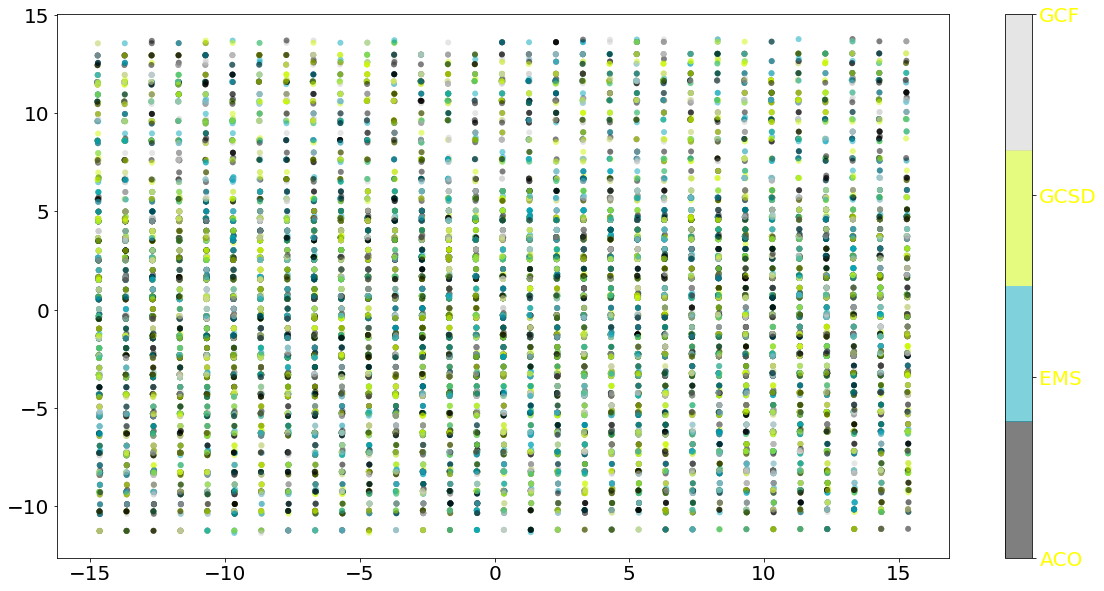

In [34]:
import matplotlib
matplotlib.rcParams['agg.path.chunksize'] = 10000
plt.figure(figsize=(20,10))
plt.scatter(comp_sample[0], comp_sample[1], c=comp_sample.agencycode, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 4))
plt.yticks(color='black', fontsize='20')
plt.xticks(color='black', fontsize='20')
plt.colorbar(ticks=[0,1,2,3]).ax.set_yticklabels(['ACO','EMS', 'GCSD', 'GCF'], color='yellow', fontsize='20')

## Data Visualization

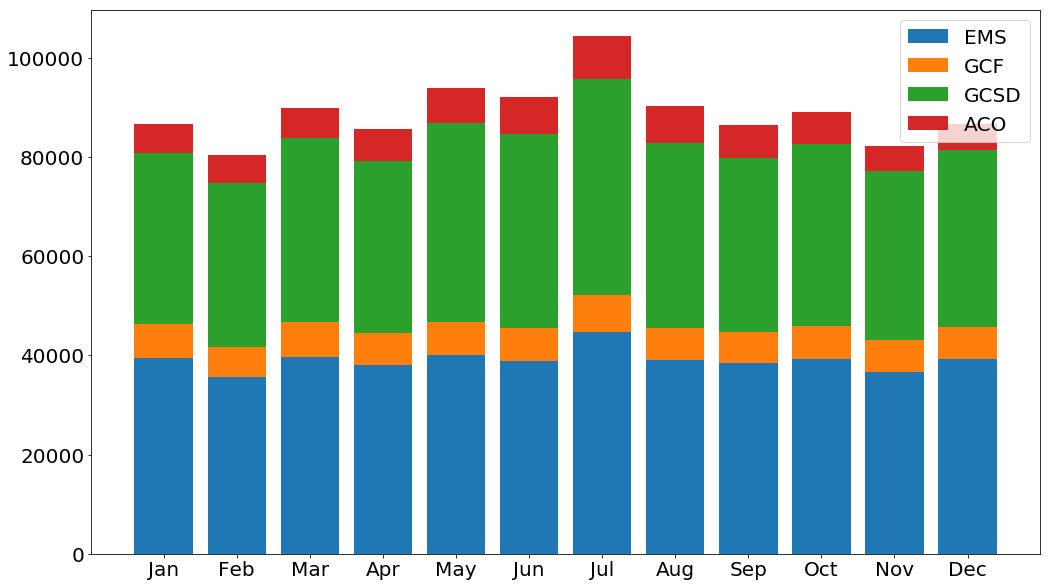

In [40]:
ems = calls[calls.agency == 'EMS'].groupby('month').agg(['count'])['agency']
gcf = calls[calls.agency == 'GCF'].groupby('month').agg(['count'])['agency']
gcsd = calls[calls.agency == 'GCSD'].groupby('month').agg(['count'])['agency']
aco = calls[calls.agency == 'ACO'].groupby('month').agg(['count'])['agency']
plt.figure(figsize=(17,10))
plt.bar(np.arange(len(ems)), ems['count'])
plt.bar(np.arange(len(ems)), gcf['count'], bottom = ems['count'])
plt.bar(np.arange(len(ems)), gcsd['count'], bottom = ems['count'] + gcf['count'])
plt.bar(np.arange(len(ems)), aco['count'], bottom = ems['count'] + gcf['count'] + gcsd['count'])
plt.xticks(range(0,12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], color='black', fontsize='20')
plt.yticks(color='black', fontsize='20')
plt.legend(['EMS', 'GCF', 'GCSD', 'ACO'], fontsize='20')

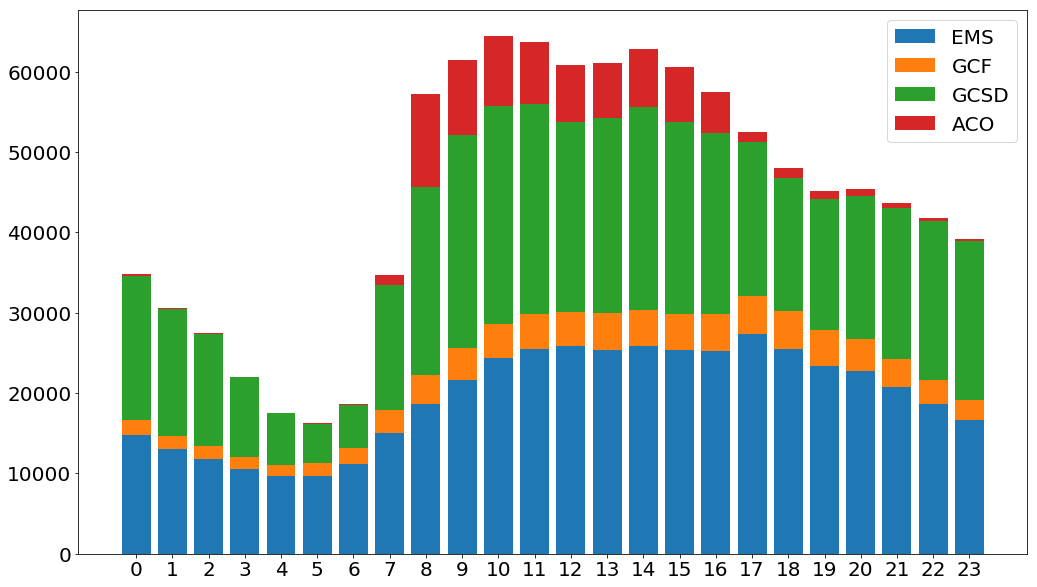

In [41]:
ems = calls[calls.agency == 'EMS'].groupby('hour').agg(['count'])['agency']
gcf = calls[calls.agency == 'GCF'].groupby('hour').agg(['count'])['agency']
gcsd = calls[calls.agency == 'GCSD'].groupby('hour').agg(['count'])['agency']
aco = calls[calls.agency == 'ACO'].groupby('hour').agg(['count'])['agency']
plt.figure(figsize=(17,10))
plt.bar(np.arange(len(ems)), ems['count'])
plt.bar(np.arange(len(ems)), gcf['count'], bottom = ems['count'])
plt.bar(np.arange(len(ems)), gcsd['count'], bottom = ems['count'] + gcf['count'])
plt.bar(np.arange(len(ems)), aco['count'], bottom = ems['count'] + gcf['count'] + gcsd['count'])
plt.xticks(range(len(ems)), color='black', fontsize='20')
plt.yticks(color='black', fontsize='20')
plt.legend(['EMS', 'GCF', 'GCSD', 'ACO'], fontsize='20')

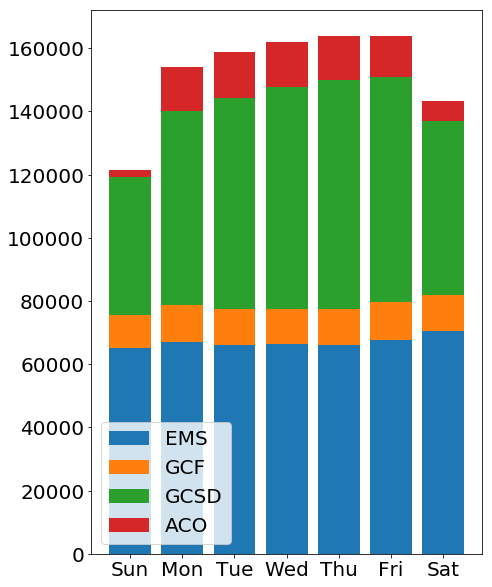

In [42]:
ems = calls[calls.agency == 'EMS'].groupby('dayOfWeek').agg(['count'])['agency']
gcf = calls[calls.agency == 'GCF'].groupby('dayOfWeek').agg(['count'])['agency']
gcsd = calls[calls.agency == 'GCSD'].groupby('dayOfWeek').agg(['count'])['agency']
aco = calls[calls.agency == 'ACO'].groupby('dayOfWeek').agg(['count'])['agency']
plt.figure(figsize=(7,10))
plt.bar(np.arange(len(ems)), ems['count'])
plt.bar(np.arange(len(ems)), gcf['count'], bottom = ems['count'])
plt.bar(np.arange(len(ems)), gcsd['count'], bottom = ems['count'] + gcf['count'])
plt.bar(np.arange(len(ems)), aco['count'], bottom = ems['count'] + gcf['count'] + gcsd['count'])
plt.xticks(range(len(ems)), ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'], color='black', fontsize='20')
plt.yticks(color='black', fontsize='20')
plt.legend(['EMS', 'GCF', 'GCSD', 'ACO'], fontsize='20')

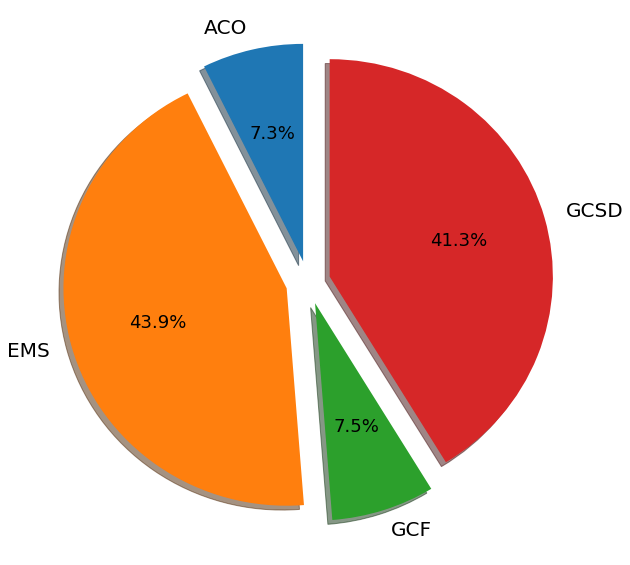

In [38]:
plt.figure(figsize=(10,10))
patches, texts, autotexts = plt.pie(calls.groupby('agency').agg(['count'])['calltime']['count'], explode=[0.1,0.1,0.1,0.1], autopct='%1.1f%%',
        shadow=True, startangle=90, labels=['ACO', 'EMS', 'GCF', 'GCSD'])
texts[0].set_fontsize(20)
texts[0].set_color('black')
texts[1].set_fontsize(20)
texts[1].set_color('black')
texts[2].set_fontsize(20)
texts[2].set_color('black')
texts[3].set_fontsize(20)
texts[3].set_color('black')
autotexts[0].set_fontsize(18)
autotexts[1].set_fontsize(18)
autotexts[2].set_fontsize(18)
autotexts[3].set_fontsize(18)

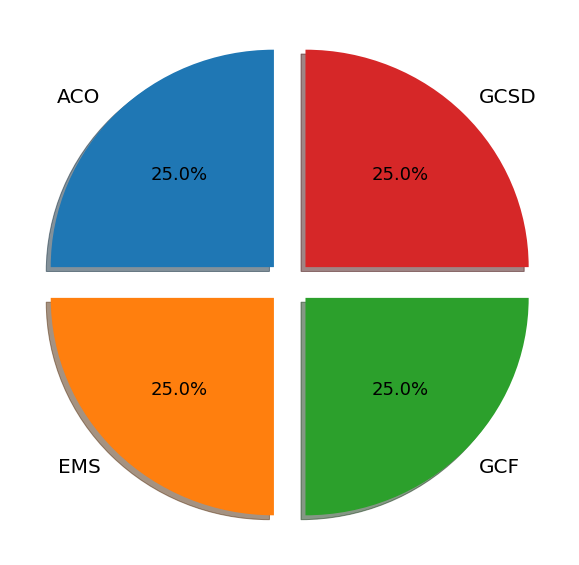

In [39]:
plt.figure(figsize=(10,10))
patches, texts, autotexts = plt.pie(balanced_calls.groupby('agency').agg(['count'])['calltime']['count'], explode=[0.1,0.1,0.1,0.1], autopct='%1.1f%%',
        shadow=True, startangle=90, labels=['ACO', 'EMS', 'GCF', 'GCSD'])
texts[0].set_fontsize(20)
texts[0].set_color('black')
texts[1].set_fontsize(20)
texts[1].set_color('black')
texts[2].set_fontsize(20)
texts[2].set_color('black')
texts[3].set_fontsize(20)
texts[3].set_color('black')
autotexts[0].set_fontsize(18)
autotexts[1].set_fontsize(18)
autotexts[2].set_fontsize(18)
autotexts[3].set_fontsize(18)